In [1]:
import torch
import numpy as np
from PIL import Image
import torchvision


class Dataset(torch.utils.data.Dataset):
    def __init__(self, part):
        self.part = part
        self.data = np.loadtxt(fname='data/%s.csv' % part, delimiter=',')

        #数据增强模块,这里不需要什么太高级的变化
        self.transforms = torchvision.transforms.ToTensor()

    def __getitem__(self, idx):
        x = Image.open('data/%s/%s.jpg' % (self.part, idx))
        x = self.transforms(x)

        y = {
            'labels': torch.LongTensor([1]),
            'boxes': torch.LongTensor([self.data[idx] * 256])
        }

        return x, y

    def __len__(self):
        return len(self.data)


def collate_fn(data):
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    return x, y


loader = torch.utils.data.DataLoader(dataset=Dataset(part='train'),
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True,
                                     collate_fn=collate_fn)

for i, (x, y) in enumerate(loader):
    break

print(len(loader), type(x), type(y), len(x), len(y))

x[0], x[0].dtype, x[0].shape, y[0]

116 <class 'list'> <class 'list'> 8 8


/root/anaconda3/envs/tt/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)


(tensor([[[0.3216, 0.3255, 0.3294,  ..., 0.1569, 0.1451, 0.1451],
          [0.3176, 0.3255, 0.3333,  ..., 0.1569, 0.1490, 0.1490],
          [0.3176, 0.3255, 0.3255,  ..., 0.1608, 0.1529, 0.1569],
          ...,
          [0.1882, 0.2235, 0.2314,  ..., 0.4118, 0.3843, 0.3569],
          [0.2196, 0.2745, 0.2078,  ..., 0.4353, 0.4431, 0.3882],
          [0.2196, 0.2314, 0.2392,  ..., 0.4275, 0.4706, 0.4235]],
 
         [[0.4196, 0.4235, 0.4275,  ..., 0.2510, 0.2392, 0.2392],
          [0.4275, 0.4353, 0.4314,  ..., 0.2510, 0.2431, 0.2431],
          [0.4275, 0.4353, 0.4353,  ..., 0.2549, 0.2471, 0.2510],
          ...,
          [0.1647, 0.1725, 0.1725,  ..., 0.3020, 0.2863, 0.2549],
          [0.2039, 0.2235, 0.1412,  ..., 0.3294, 0.3569, 0.3059],
          [0.2039, 0.1804, 0.1725,  ..., 0.3216, 0.3843, 0.3451]],
 
         [[0.6784, 0.6824, 0.6863,  ..., 0.5255, 0.5137, 0.5137],
          [0.6824, 0.6902, 0.6902,  ..., 0.5255, 0.5255, 0.5255],
          [0.6824, 0.6902, 0.6902,  ...,

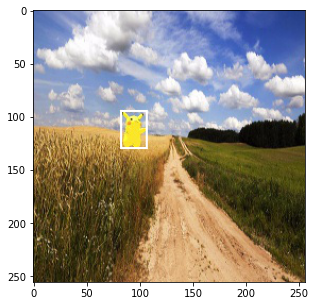

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import PIL.Image
import PIL.ImageDraw


#画出anchor
def show(x, y, out):
    x = x.detach().numpy() * 255.0
    x = x.astype(np.uint8)

    #(3, 256, 256) -> (256, 256, 3)
    x = x.transpose((1, 0, 2))
    x = x.transpose((0, 2, 1))

    y = y.detach().tolist()

    image = PIL.Image.fromarray(x)
    draw = PIL.ImageDraw.Draw(image)

    draw.rectangle(xy=y, outline='white', width=2)

    if out and len(out['scores']) > 0:
        idx = out['scores'].argmax().item()
        draw.rectangle(xy=out['boxes'][idx].tolist(), outline='black', width=2)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()


show(x[0], y[0]['boxes'][0], None)

In [3]:
#使用自己定义的网络
#就是个简单的cnn网络
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

#rcnn需要知道backbone输出的通道数
backbone.out_channels = 1280

#定位框生成器,这里的size就是框的尺寸,ratio = height / width
#所以生成的是1*1个定位框,1个不同的尺寸和1个不同的比例
anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(
   sizes=((25), ), aspect_ratios=((1.0), ))

#在哪些特征层上进行roi pooling,roi_pooling输出特征矩阵尺寸,采样率
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                               output_size=[7, 7],
                                               sampling_ratio=2)

#创建模型
model = torchvision.models.detection.FasterRCNN(
   backbone=backbone,
   #目标类别总共分2类,包括背景0,也就是有1种物体
   num_classes=2,
   rpn_anchor_generator=anchor_generator,
   box_roi_pool=roi_pooler,
   min_size=256,
   max_size=256,
   rpn_pre_nms_top_n_train=500,
   rpn_pre_nms_top_n_test=500,
   rpn_post_nms_top_n_train=500,
   rpn_post_nms_top_n_test=500)

print(sum(p.numel() for p in model.parameters()) / 10000)

model(x, y)

8226.3311


/root/anaconda3/envs/tt/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'loss_classifier': tensor(0.7738, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0055, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.6441, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0368, grad_fn=<DivBackward0>)}

In [4]:
#使用预训练的网络
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True,
    progress=True,
    num_classes=91,
    pretrained_backbone=True,
    trainable_backbone_layers=None)

#重新设定物品的类别数
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features=1024,
                                                          out_features=2)
model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(in_features=1024,
                                                          out_features=8)

#性能原因,改小尺寸,不然根本算不动
model.transform = torchvision.models.detection.transform.GeneralizedRCNNTransform(
    min_size=256,
    max_size=256,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225])

model.train()

print(sum(p.numel() for p in model.parameters()) / 10000)

model(x, y)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

4129.9161


{'loss_classifier': tensor(1.0525, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0935, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.1740, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0046, grad_fn=<DivBackward0>)}

In [5]:
#冻结backbone部分底层权重
for name, p in model.backbone.named_parameters():
    if name in [
            #预训练模型

            #自己创建的模型
            '0.0.weight',
            '0.1.weight',
            '0.1.bias',
            '1.conv.0.0.weight',
            '1.conv.0.1.weight',
            '1.conv.0.1.bias',
            '1.conv.1.weight',
            '1.conv.2.weight',
            '1.conv.2.bias',
            '2.conv.0.0.weight',
            '2.conv.0.1.weight',
            '2.conv.0.1.bias',
            '2.conv.1.0.weight',
            '2.conv.1.1.weight',
            '2.conv.1.1.bias',
            '2.conv.2.weight',
            '2.conv.3.weight',
            '2.conv.3.bias',
            '3.conv.0.0.weight',
            '3.conv.0.1.weight',
            '3.conv.0.1.bias',
            '3.conv.1.0.weight',
            '3.conv.1.1.weight',
            '3.conv.1.1.bias',
            '3.conv.2.weight',
            '3.conv.3.weight',
            '3.conv.3.bias',
    ]:
        print(name, '--', False)
        p.requires_grad = False
    else:
        p.requires_grad = True

params = [p for p in model.parameters() if p.requires_grad]

sum(p.numel() for p in params) / 10000

4129.9161

In [6]:
def train():
    model.train()
    optimizer = torch.optim.SGD(params, lr=1e-3)
    for epoch in range(30):
        for i, (x, y) in enumerate(loader):
            outs = model(x, y)
            loss = outs['loss_classifier'] + outs['loss_box_reg'] + outs[
                'loss_objectness'] + outs['loss_rpn_box_reg']
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 10 == 0:
                print(epoch, i, loss.item())

        torch.save(model, 'rcnn.model')


#train()

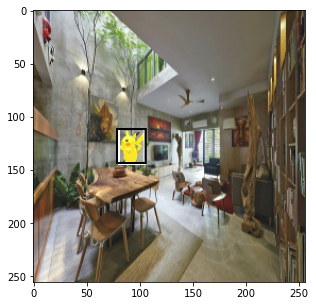

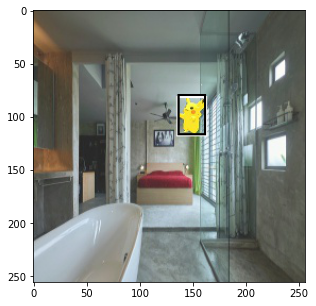

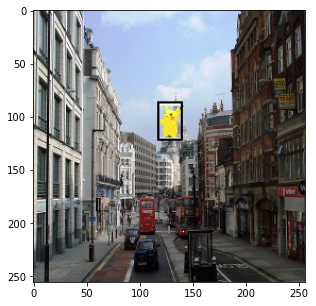

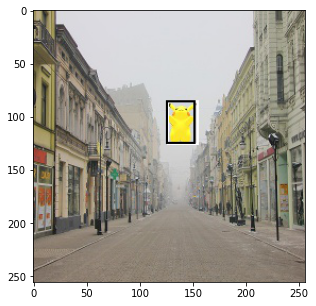

In [7]:
def test():
    loader_test = torch.utils.data.DataLoader(dataset=Dataset(part='test'),
                                              batch_size=4,
                                              shuffle=True,
                                              drop_last=True,
                                              collate_fn=collate_fn)

    for i, (x, y) in enumerate(loader_test):
        break

    model_load = torch.load('rcnn.model')
    model_load.eval()

    with torch.no_grad():
        outs = model_load(x)

    for i in range(4):
        show(x[i], y[i]['boxes'][0], outs[i])


test()